# Correlation Analysis

Preliminary feature selection based on correlation analysis with baseline logistic regression model.

## Preprocess

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import os
import string
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVR
from sklearn.decomposition import PCA

pd.reset_option('all')

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
DIR = "../../data/"
SMOOTHIE = "Smoothie King/smoothie_king_"

In [4]:
smoothie_demographic = pd.read_csv(DIR + SMOOTHIE + "demographic_variables.csv")
smoothie_stores = pd.read_csv(DIR + SMOOTHIE + "stores.csv")
smoothie_poi_variables = pd.read_csv(DIR + SMOOTHIE + "poi_variables.csv")
smoothie_sister = pd.read_csv(DIR + SMOOTHIE + "competition_sister_variables.csv")
smoothie_trade_area = pd.read_csv(DIR + SMOOTHIE + "trade_area_variables.csv").rename(columns={"store_num": "store"})

In [5]:
smoothie_merged = smoothie_stores.merge(
    smoothie_demographic, on="store", how="outer"
).merge(
    smoothie_poi_variables, on="store", how="outer"
).merge(
    smoothie_sister, on="store", how="outer"
).merge(
    smoothie_trade_area, on="store", how="outer"
)
# smoothie_merged.to_csv(DIR + SMOOTHIE + "merged.csv")

In [6]:
# smoothie_merged = smoothie_stores.merge(
#     smoothie_poi_variables, on="store", how="outer"
# ).merge(
#     smoothie_sister, on="store", how="outer"
# ).merge(
#     smoothie_trade_area, on="store", how="outer"
# )

In [7]:
train_df, test_df = train_test_split(smoothie_merged, test_size=0.1, random_state=42)
X_train = train_df.drop(columns=["category"])
y_train = train_df["category"]
X_test = test_df.drop(columns=["category"])
y_test = test_df["category"]

In [8]:
drop_features = ["store", "longitude", "latitude", "__store_latitude"]
ordinal_features_oth = [
    "market_size",
    "store_density",
]
ordering_ordinal_oth = [
    ["Very Large Metro (1)", "Large Metro (2)", "Large City (3)", "Medium City (4)", "Small City (5)", "Small Town (6)"],
    ["Rural", "Exurban", "Suburban", "Light Suburban", "Light Urban", "Urban", "Super Urban"],
]
categorical_features = ["cbsa_name", "dma_name", "state_name"]

numeric_features = list(set(smoothie_merged.select_dtypes(include=np.number).columns.tolist()) - {"longitude", "latitude"})

In [9]:
numeric_transformer = make_pipeline(
    SimpleImputer(strategy="median"), 
    StandardScaler()
)

ordinal_transformer_oth = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=ordering_ordinal_oth),
)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore", sparse=False),
)

preprocessor = make_column_transformer(
    ("drop", drop_features),
    (numeric_transformer, numeric_features),
    (ordinal_transformer_oth, ordinal_features_oth),
    (categorical_transformer, categorical_features),
)

In [10]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('drop', 'drop',
                                 ['store', 'longitude', 'latitude',
                                  '__store_latitude']),
                                ('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['dtpop_students_post_secondary_p_3mi',
                                  'occhu_1mi', 'hh_1pers_p_5mi',
                                  'dtpop_homemakers_2mi', 'white_2mi',
                                  'edu_doctorate_p_ta', 'gq_mil...
                                                                              'Town '
                                                                              '(6)'],
                                                                             ['Rural',
                                                                              'Exurban',
                                                                              'Suburban',
                                                                              'Light '
                                                                              'Suburban',
                                                                              'Light '
                                                                              'Urban',
                                                                              'Urban',
                                                                              'Super '
                                                                              'Urban']]))]),
                                 ['market_size', 'store_density']),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['cbsa_name', 'dma_name', 'state_name'])])

In [11]:
column_names = (
    numeric_features
    + preprocessor.named_transformers_['pipeline-2']['ordinalencoder'].get_feature_names_out().tolist()
    + preprocessor.named_transformers_['pipeline-3']['onehotencoder'].get_feature_names_out().tolist()
)
len(column_names)

1635

In [12]:
transformed_X = preprocessor.transform(X_train)
# X_test_processed = preprocessor.transform(X_test)

In [13]:
transformed_X_df = pd.DataFrame(transformed_X, columns=column_names)
transformed_X_df

,dtpop_students_post_secondary_p_3mi,occhu_1mi,hh_1pers_p_5mi,dtpop_homemakers_2mi,white_2mi,edu_doctorate_p_ta,gq_military_p_ta,hh_type_married_nochild_2mi,edu_doctorate_2mi,popgr10cn_ta,...,x2_North Carolina,x2_Ohio,x2_Oklahoma,x2_Pennsylvania,x2_South Carolina,x2_Tennessee,x2_Texas,x2_Virginia,x2_West Virginia,x2_Wisconsin
0,0.064795,-0.485151,-1.565117,-0.317496,-0.063400,0.467448,-0.170497,-0.526645,-0.009390,0.649993,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.820031,0.692457,0.995922,-0.274644,1.840820,0.136757,-0.170497,1.104113,0.692417,-0.440305,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.155974,-0.338554,-1.829464,0.093302,-0.229656,-0.355905,-0.170497,0.313768,-0.211511,0.657656,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.965856,0.134808,-1.053478,0.253456,0.187744,-0.740586,-0.170497,0.345954,-0.438896,-0.258480,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.569476,-0.475732,-0.645587,-0.553537,0.192624,-0.430141,-0.170497,-0.121101,-0.353276,-0.382454,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,0.052530,1.075494,1.720745,0.045424,1.703751,0.386463,-0.170497,0.753286,0.554863,-0.283682,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
712,0.452015,-0.556639,0.478598,-0.138190,-0.439705,0.022028,-0.170497,-0.178678,-0.180631,0.196126,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
713,1.932565,-0.150175,-1.278030,0.227841,-0.066911,-0.619108,-0.170497,-0.187977,-0.546974,0.849818,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
714,-0.324178,-0.172877,1.257427,-0.455864,-0.524567,-0.119697,-0.170497,-0.422577,-0.210107,-0.484253,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Logistic Regression (One vs Rest)

**Overview**: 

Starting with a general correlation analysis with significant features (results from LR model). 

For each category:
1. find most important features in LR model (highest abs value of coeff)
2. exclude highly correlated features (from the pair, exclude the one that is less correlated to the target)

**Target**: 

Select most important features for each category

In [14]:
pipe_lr = make_pipeline(
    preprocessor,
    LogisticRegression(penalty="l1", random_state=42, solver="saga", max_iter=10000, multi_class="ovr", n_jobs=-1)
)
pipe_lr.fit(X_train, y_train)
print(pipe_lr.score(X_train, y_train))
print(pipe_lr.score(X_test, y_test))

0.8854748603351955
0.5125


In [15]:
pipe_lr.named_steps["logisticregression"].classes_

array(['HOME', 'OTHER', 'SHOPPING', 'TRAVEL', 'WORK'], dtype=object)

In [16]:
lr_coefs = pd.DataFrame(
    pipe_lr.named_steps["logisticregression"].coef_, 
    index=pipe_lr.named_steps["logisticregression"].classes_,
    columns=column_names
)
lr_coefs

,dtpop_students_post_secondary_p_3mi,occhu_1mi,hh_1pers_p_5mi,dtpop_homemakers_2mi,white_2mi,edu_doctorate_p_ta,gq_military_p_ta,hh_type_married_nochild_2mi,edu_doctorate_2mi,popgr10cn_ta,...,x2_North Carolina,x2_Ohio,x2_Oklahoma,x2_Pennsylvania,x2_South Carolina,x2_Tennessee,x2_Texas,x2_Virginia,x2_West Virginia,x2_Wisconsin
HOME,0.000000,0.000000,0.000000,0.000000,0.000000,0.092825,0.145648,0.000000,0.000000,0.235394,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
OTHER,-0.014976,0.013671,0.011803,0.000000,0.000000,0.062860,0.058475,0.004314,0.076569,0.000000,...,-0.058079,-0.001787,0.0,0.000000,-0.016424,-0.014782,-0.127680,0.0,0.0,0.0
SHOPPING,0.018969,0.000000,0.000000,0.000000,0.004775,0.000000,-0.111910,0.000000,-0.088922,-0.013115,...,0.125511,0.000000,0.0,-0.008908,0.000000,0.025991,-0.097546,0.0,0.0,0.0
TRAVEL,-0.044605,0.000000,0.000000,0.001283,0.008658,-0.135653,-0.024261,0.000000,-0.012689,0.000000,...,-0.060479,0.000000,0.0,0.000000,0.000000,-0.017754,-0.190565,0.0,0.0,0.0
WORK,0.051175,0.000000,-0.024606,0.000000,0.000000,-0.041843,0.000000,0.023830,0.000000,-0.006141,...,0.000000,0.000000,0.0,0.000000,0.000000,-0.048605,-0.215493,0.0,0.0,0.0


### Helpers functions to be moved to python file

In [17]:
def get_sig_features(coef_df, threshold=0.2):
    abs_target_df = coef_df.abs()
    sig_feat = abs_target_df[abs_target_df > threshold].sort_values(ascending=False)
    return sig_feat

In [18]:
def target_corr_df(raw_X, raw_y, target_name, feature_index):
    target_df = raw_X[feature_index]
    target_df["target"] = raw_y.apply(lambda x: 1 if x == target_name else 0)
    target_corr = target_df.corr()
    return target_corr

def corr_pair(target_corr, corr_threshold=0.7):
    np.fill_diagonal(target_corr.values, 0)
    sorted_pair = target_corr.abs().unstack().sort_values(kind="quicksort", ascending=False)
    return sorted_pair[sorted_pair > corr_threshold]

In [19]:
def corr_pair_drop(feature_pairs, corr_with_target):
    selected, discarded = [], []
    for f1, f2 in feature_pairs:
        if abs(corr_with_target[f1]) < abs(corr_with_target[f2]):
            selected.append(f2)
            discarded.append(f1)
        else:
            selected.append(f1)
            discarded.append(f2)
    final_discarded = set(discarded) - set(selected) 
    return list(final_discarded)

In [20]:
def plot_heatmap(target_corr, target_name, corr_filter=0.55):
    temp_corr = target_corr.abs()
    corr_features = temp_corr.loc[:, (temp_corr > corr_filter).any(axis=0)].columns.sort_values()
    # corr_features.add("target")
    highly_corr = target_corr.loc[corr_features, corr_features]
    f, ax = plt.subplots(figsize=(12, 12))
    mask = np.triu(np.ones_like(highly_corr, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    ax.set_title(target_name)
    sns.heatmap(highly_corr, annot=False, mask=mask, cmap=cmap)

### General Correlation Analysis (transformed data)

In [21]:
general_sig_features = get_sig_features(lr_coefs.loc["HOME"], threshold=0.01).index.tolist()
general_sig_features.extend(get_sig_features(lr_coefs.loc["OTHER"], threshold=0.01).index.tolist())
general_sig_features.extend(get_sig_features(lr_coefs.loc["SHOPPING"], threshold=0.01).index.tolist())
general_sig_features.extend(get_sig_features(lr_coefs.loc["WORK"], threshold=0.01).index.tolist())
general_sig_features.extend(get_sig_features(lr_coefs.loc["TRAVEL"], threshold=0.01).index.tolist())
general_sig_features = list(set(general_sig_features))

In [22]:
sig_transformed_X = transformed_X_df[general_sig_features]
sig_transformed_X

,emp_finance_insurance_p_5mi,medhhinc_3mi,dtpop_students_post_secondary_p_3mi,dtpop_students_9th_12th_p_3mi,occhu_1mi,hh_1pers_p_5mi,gq_military_p_ta,edu_doctorate_p_ta,hh_7pers_10mi,edu_doctorate_2mi,...,hh_inc_gt_75k_p_ta,hh_5pers_1mi,occ_bc_p_10mi,centerxy_gla_effective_1mi,hh_type_male_p_10mi,dtpop_retired_disabled_1mi,millenial_p_2mi,hhinc100pl_ta,emp_educ_services_p_ta,hh_7pers_5mi
0,-0.836627,1.687705,0.064795,3.297618,-0.485151,-1.565117,-0.170497,0.467448,-0.455552,-0.009390,...,1.346013,0.019284,-0.293874,-0.938031,-0.620792,-0.353163,-1.840850,3.538390,1.082907,-0.440121
1,0.606408,0.534478,-0.820031,-0.628674,0.692457,0.995922,-0.170497,0.136757,0.568220,0.692417,...,0.708516,-0.078235,-1.149594,-0.762372,0.458950,0.657564,-1.267476,2.160164,-0.809371,-0.063130
2,-0.967416,2.289622,-0.155974,1.967745,-0.338554,-1.829464,-0.170497,-0.355905,0.405555,-0.211511,...,1.649085,0.432307,-0.656758,-0.062242,-0.225530,0.037452,-1.090686,-0.004588,-0.269969,0.012011
3,-0.915100,0.171105,1.965856,-0.502019,0.134808,-1.053478,-0.170497,-0.740586,0.743085,-0.438896,...,0.170301,0.965795,0.625595,-0.152329,2.030359,0.195759,0.481315,-0.018273,0.259227,0.200828
4,0.000420,1.907407,-0.569476,0.447890,-0.475732,-0.645587,-0.170497,-0.430141,-0.451486,-0.353276,...,1.381097,-0.135599,-1.358007,-0.138064,-0.746119,-0.296022,-0.703658,1.228325,0.114901,-0.283416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,1.194956,0.577204,0.052530,-1.641910,1.075494,1.720745,-0.170497,0.386463,0.186567,0.554863,...,1.017560,0.134013,0.954153,-0.569566,-0.013438,0.101149,0.777559,0.124053,-0.590694,0.185415
712,-0.169605,-0.294113,0.452015,-0.248710,-0.556639,0.478598,-0.170497,0.022028,-0.592394,-0.180631,...,-0.161884,-0.778079,-0.848008,0.373979,0.333622,-0.779373,-0.522090,0.171827,-0.577574,-0.532603
713,3.658142,1.040495,1.932565,0.257908,-0.150175,-1.278030,-0.170497,-0.619108,-0.179022,-0.546974,...,1.068321,0.759283,-0.090365,-0.265281,-1.189585,-0.960161,-0.545980,0.726451,0.638266,0.009442
714,0.288155,-0.977904,-0.324178,-0.881983,-0.172877,1.257427,-0.170497,-0.119697,-0.423223,-0.210107,...,-0.395533,-0.256064,-0.512095,0.182815,-0.476184,-0.234198,0.371419,-1.129762,-0.606731,-0.331584


In [23]:
general_pair_attr = corr_pair(sig_transformed_X.corr())
# general_pair_df = pd.DataFrame(
#     zip(general_pair_attr.index.get_level_values(1), general_pair_attr.values), 
#     index=general_pair_attr.index.get_level_values(0),
#     columns=["the other", "corr"])
# general_pair_df

In [24]:
max_coef_df = lr_coefs.transpose().abs().max(axis=1)

In [25]:
general_drop_column = corr_pair_drop(general_pair_attr.index, max_coef_df)
len(general_drop_column)

69

In [26]:
keep_columns = list(set(general_sig_features) - set(general_drop_column))

transformed_X_test_df = pd.DataFrame(preprocessor.transform(X_test), columns=column_names)

reduced_X_train = transformed_X_df[keep_columns]
reduced_X_test = transformed_X_test_df[keep_columns]

In [27]:
reduced_lr = LogisticRegression(penalty="l1", random_state=42, solver="saga", max_iter=10000, multi_class="ovr", n_jobs=-1)

reduced_lr.fit(reduced_X_train, y_train)
print(reduced_lr.score(reduced_X_train, y_train))
print(reduced_lr.score(reduced_X_test, y_test))

0.9162011173184358
0.4875


### HOME

Keyword: Education

In [28]:
home_coefs = lr_coefs.loc["HOME"]
home_sig_features = get_sig_features(home_coefs)
home_coefs = home_coefs[home_sig_features.index]

alt.Chart(
    pd.DataFrame(zip(home_coefs.index, home_coefs.values), columns=["feature_name", "coef"]),
    title="HOME Coefficients",
).mark_bar().encode(y=alt.Y("feature_name", sort="x"), x="coef")

alt.Chart(...)

In [29]:
home_corr = target_corr_df(transformed_X_df, y_train, "HOME", home_sig_features.index)

/var/folders/t1/c4fmzstn5v92jwsl8z5vhpp40000gn/T/ipykernel_24898/2993323763.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df["target"] = raw_y.apply(lambda x: 1 if x == target_name else 0)


In [30]:
home_pair_attr = corr_pair(home_corr)
home_pair_df = pd.DataFrame(
    zip(home_pair_attr.index.get_level_values(1), home_pair_attr.values), 
    index=home_pair_attr.index.get_level_values(0),
    columns=["the other", "corr"])
home_pair_df = home_pair_df.merge(home_corr["target"], how="inner", left_index=True, right_index=True)
home_pair_df

,the other,corr,target
dtpop_homemakers_p_10mi,dtpop_homemakers_p_ta,0.718813,-0.002877
dtpop_homemakers_p_ta,dtpop_homemakers_p_10mi,0.718813,-0.029973
dtpop_work_at_home_p_5mi,dtpop_work_at_home_ta,0.727407,-0.044851
dtpop_work_at_home_ta,dtpop_work_at_home_p_5mi,0.727407,-0.019626
edu_highsch_p_5mi,hh_inc_gt_500k_p_ta,0.644888,-0.005282
edu_somecollege_1mi,hh_type_married_child_1mi,0.730627,0.011321
emp_management_p_1mi,emp_management_p_2mi,0.783216,0.057284
emp_management_p_2mi,emp_management_p_1mi,0.783216,0.035198
emp_mining_p_1mi,emp_mining_p_ta,0.801943,0.003772
emp_mining_p_1mi,emp_mining_p_5mi,0.642340,0.003772


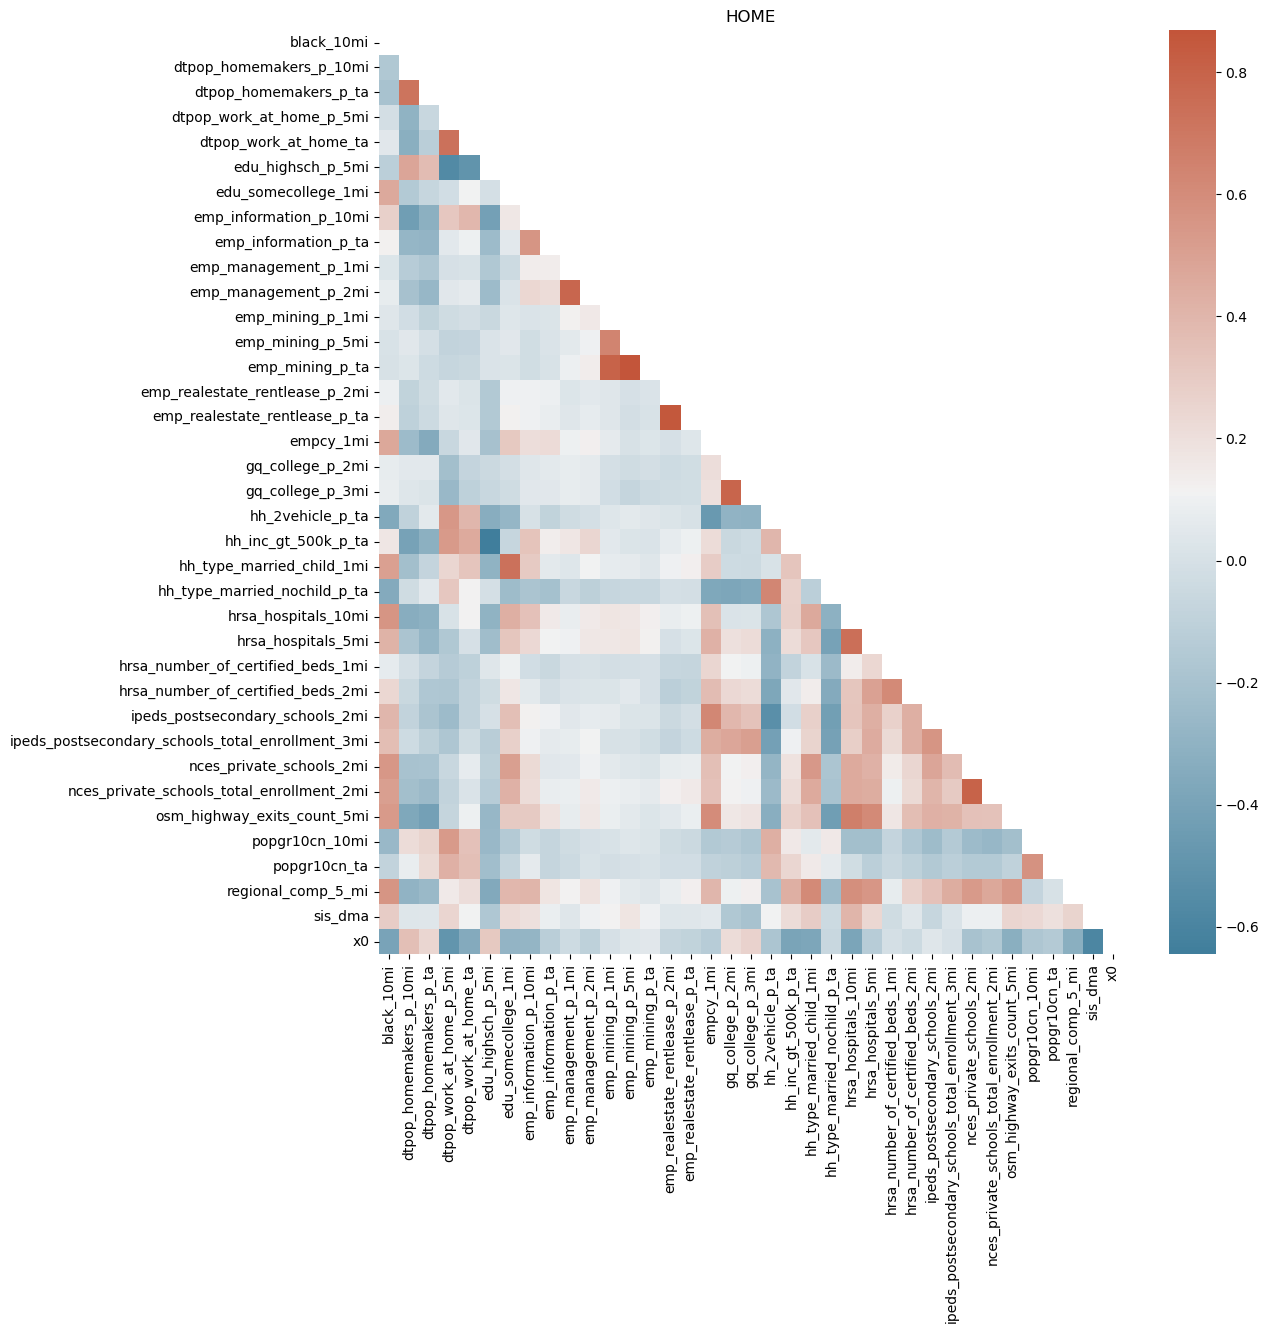

In [31]:
plot_heatmap(home_corr, "HOME")

In [32]:
home_feat_drop = corr_pair_drop(home_pair_attr.index, home_corr["target"])
home_feat_drop

['ipeds_postsecondary_schools_2mi',
 'hh_2vehicle_p_ta',
 'hrsa_number_of_certified_beds_1mi',
 'hrsa_hospitals_5mi',
 'edu_somecollege_1mi',
 'gq_college_p_2mi',
 'emp_mining_p_1mi',
 'emp_realestate_rentlease_p_2mi',
 'dtpop_homemakers_p_10mi',
 'edu_highsch_p_5mi',
 'emp_management_p_2mi',
 'dtpop_work_at_home_ta',
 'nces_private_schools_total_enrollment_2mi']

### SHOPPING

Keyword: wholesale_trade, college, centerxy

In [33]:
sorted_coefs = lr_coefs.loc["SHOPPING"].abs().sort_values(ascending = False)
shop_coefs = lr_coefs.loc["SHOPPING"][sorted_coefs.index]
print(shop_coefs[:20].index)

Index(['x0', 'emp_wholesale_trade_p_1mi', 'military_installations_1mi',
       'gq_college_p_1mi', 'emp_other_p_1mi', 'transitstop_nearest_dist',
       'centerxy_count_3mi', 'x1', 'emp_accommodation_foodserv_p_2mi',
       'emp_arts_entertainment_p_2mi', 'osm_highway_exits_count_3mi',
       'ipeds_postsecondary_schools_2mi', 'hh_3vehicle_p_1mi', 'banks_1mi',
       'centerxy_0p5_intersect_count', 'emp_information_p_ta',
       'emp_realestate_rentlease_p_5mi', 'national_comp_adjacent',
       'pop_transient_1mi', 'dmm_nearest_dist'],
      dtype='object')


### TRAVEL

In [34]:
sorted_coefs = lr_coefs.loc["TRAVEL"].abs().sort_values(ascending = False)
travel_coefs = lr_coefs.loc["TRAVEL"][sorted_coefs.index]
travel_coefs[:20]

x1                                 -1.221348
x0                                 -0.692691
pop_transient_ta                    0.191347
x2_Texas                           -0.190565
transitstop_nearest_dist            0.180740
poverty_inpoverty_p_1mi             0.169153
national_comp_3_mi                  0.163812
emp_realestate_rentlease_p_5mi      0.142367
ipeds_postsecondary_nearest_dist    0.141300
emp_management_p_3mi                0.139945
inrix_ns_distance                   0.137407
edu_doctorate_p_ta                 -0.135653
poverty_inpoverty_p_10mi            0.131350
regional_comp_adjacent             -0.124904
medhhinc_dma                       -0.120559
gq_college_p_1mi                    0.117119
pop_seasonal_3mi                    0.116514
pop_seasonal_1mi                    0.115970
hh_type_nonfam_p_1mi                0.115896
com0811_p_10mi                     -0.115353
Name: TRAVEL, dtype: float64

### WORK

In [35]:
sorted_coefs = lr_coefs.loc["WORK"].abs().sort_values(ascending = False)
work_coefs = lr_coefs.loc["WORK"][sorted_coefs.index]
work_coefs[:20]

x1                                          -0.576085
centerxy_full_0p5_intersect_count           -0.302252
x0                                          -0.251962
other_p_1mi                                 -0.251405
inrix_aadt_ew                                0.250355
gq_other_p_1mi                               0.243402
emp_wholesale_trade_p_1mi                    0.239325
emp_information_p_1mi                        0.238203
age0018_p_1mi                                0.238123
gq_college_p_3mi                             0.224641
x2_Texas                                    -0.215493
hh_2pers_p_2mi                               0.209238
asian_p_10mi                                 0.207617
nces_private_schools_total_enrollment_1mi    0.207201
military_installations_10mi                 -0.202629
hh_type_female_nochild_p_1mi                 0.198769
nces_private_schools_total_enrollment_2mi    0.195133
centerxy_0p5_intersect_count                -0.188921
regional_comp_adjacent      

### OTHER

In [36]:
sorted_coefs = lr_coefs.loc["OTHER"].abs().sort_values(ascending = False)
work_coefs = lr_coefs.loc["OTHER"][sorted_coefs.index]
# important_features.extend(sorted_coefs.index[:30])
work_coefs[:30]

x1                                          -0.673869
x0                                          -0.596265
gq_college_p_1mi                             0.344592
inrix_ns_distance                           -0.326439
emp_management_p_1mi                        -0.297158
hrsa_hospitals_nearest_dist                 -0.295248
hh_5vehicle_p_1mi                           -0.253796
nces_private_schools_total_enrollment_1mi    0.233341
gq_other_p_3mi                              -0.233110
emp_accommodation_foodserv_p_ta              0.226838
centerxy_full_0p5_intersect_count           -0.212082
emp_arts_entertainment_p_2mi                 0.209309
emp_publicadmin_p_ta                        -0.201424
transitstop_nearest_dist                     0.190491
national_comp_3_mi                          -0.186939
dmm_nearest_dist                             0.173568
gq_college_p_10mi                           -0.171176
dtpop_work_at_home_p_3mi                    -0.170777
hh_type_male_nochild_p_10mi 